### 07 AI Agent Workflow + RAG on Gradio UI
gpt-oss:20bを使用する構成のため、**Colab GPU は L4 を使用すること。**

#### コア機能と実装の概要
- 必要なライブラリをインストール
- Google Colab に Ollama をセットアップ
  - LLM モデルは gpt-oss:20b を使用（Ollama）
  - Embedding モデルは ruri-v3-310m を使用（Sentence Transformers）
  - Reranker モデルは cl-nagoya/ruri-v3-reranker-310m を使用（Sentence Transformers）
- JAXA（宇宙航空研究開発機構）のリポジトリからデータをダウンロードして読み込み
> [井澤克彦, 市川信一郎, 高速回転ホイール: 高速回転ホイール開発を通しての知見, 宇宙航空研究開発機構研究開発報告, 2008](https://jaxa.repo.nii.ac.jp/records/2149)
- データの前処理
  - markdown に変換（MarkItDown を使用）
  - Unicode正規化 (NFKC), 1文字行ブロックの除去, 空行圧縮
  - チャンク分割
    - LangChain の SpacyTextSplitter を使用
    - spaCy の日本語モデルは、ja_ginza を使用
- ベクトルデータベースの構築（ChromaDB, インメモリ）
- 検索機能の実装
  - キーワード検索 @ BM25（spaCyで形態素解析の前処理が必要）
  - Embedding model によるセマンティック検索
  - ハイブリッド検索
  - Reranker による再順位付け
  - 検索機能をLLM の tool として定義
- LangGraph による Workflow の実装
  1. ユーザの質問を入力。
  2. ユーザの質問に回答するためのタスク分割, 作成。
  3. tool による検索。
  4. tool による検索を終えて回答作成に進むか判断。再調査なら 3 に戻る。
  5. ユーザへの回答の作成と提示。

#### Gradio UI 機能
- Google Colab 環境で Gradio を立ち上げする。
- Gradio UI に PDFファイルをドラッグアンドドロップで入力する。
- PDF ファイルが入力されたら、markdown に変換・前処理する。
- Gradio UI にチャットインターフェース（ユーザ入力 / AI 回答）を設ける。
- チャットインタフェースとは別に、AI の思考過程を表示する。（タスクの内容、検索の内容、判断結果）
- AI チャットは、マルチターン対応、ストリーミング応答を行う。
- ユーザ入力 / AI 回答とも、画面をスクロールして、会話履歴含めた全文を確認できるようにする。
- **会話クリアボタン**: PDF を保持したまま会話履歴をリセットし、新しいスレッドで再質問できる。
- **システムプロンプト設定**: アコーディオン内で自由に編集可能。デフォルトは「日本語で回答してください。」
- **Temperature スライダー**: LLM の応答の正確さ/創造性を 0.0〜1.0 で調整できる。
- **生成停止ボタン**: ストリーミング中の応答を途中で中断できる。

**必要なライブラリをインストール**

In [1]:
# Google Colab に必要なライブラリをインストールする。
# 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
# NOTE: Colab では uv ではなく pip を使う。uv は依存解決の過程で
#       numpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。
# NOTE: langchain 関連は 1.x 系に明示的に指定する。
#       Colab プリインストールの 0.3.x が残ると langchain-mcp-adapters が動作しない。
# Pythonのリストとして定義することで、Pylanceの警告を防ぎ、可読性を高める。

# fmt: off
pkgs = [
    "ollama", "langchain-ollama",
    "langchain>=1.2.8", "langchain-core>=1.2.8", "langgraph>=1.0.7",
    "markitdown[all]", "chromadb", "langchain-text-splitters>=0.3",
    "spacy", "ginza", "ja-ginza", "rank-bm25",
    "sentence-transformers",
    "gradio>=6.0",
]
# fmt: on

# リストを結合して pip に渡す
# magic command内で {変数} を使うと展開される機能を利用
%pip install -U -q {" ".join(pkgs)}

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-exporter-otlp-proto-http 1.38.0 requires opentelemetry-exporter-otlp-proto-common==1.38.0, but you have opentelemetry-exporter-otlp-proto-common 1.39.1 which is incompatible.
opentelemetry-exporter-otlp-proto-http 1.38.0 requires opentelemetry-proto==1.38.0, but you have opentelemetry-proto 1.39.1 which is incompatible.
opentelemetry-exporter-otlp-proto-http 1.38.0 requires opentelemetry-sdk~=1.38.0, but you have opentelemetry-sdk 1.39.1 which is incompatible.
opentelemetry-exporter-gcp-logging 1.11.0a0 requires opentelemetry-sdk<1.39.0,>=1.35.0, but you have opentelemetry-sdk 1.39.1 which is incompatible.


**Google Colab に Ollama をセットアップ**
- 詳細は [01_connect_oss_llm.ipynb](01_connect_oss_llm.ipynb) を参照。

In [2]:
# Ollama のインストール・起動・モデルのダウンロード
# 詳細は 01_connect_oss_llm.ipynb を参照
import subprocess
import time
import ollama  # type: ignore

!apt-get install -y -qq zstd
!curl -fsSL https://ollama.com/install.sh | sh

process = subprocess.Popen(
    ["ollama", "serve"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL,
)
time.sleep(5)


def ollama_pull(model: str) -> None:
    """Ollama モデルをダウンロードし、進捗をインライン表示する。"""
    for progress in ollama.pull(model, stream=True):
        status = progress.get("status", "")
        total = progress.get("total") or 0
        completed = progress.get("completed") or 0
        if total:
            line = f"{status}: {completed / total:.0%}"
        else:
            line = status
        print(f"\r{line:<60}", end="", flush=True)
    print(f"\n{model}: Done!")


model_name = "gpt-oss:20b"
ollama_pull(model_name)
!ollama show {model_name}

Selecting previously unselected package zstd.
(Reading database ... 121852 files and directories currently installed.)
Preparing to unpack .../zstd_1.4.8+dfsg-3build1_amd64.deb ...
Unpacking zstd (1.4.8+dfsg-3build1) ...
Setting up zstd (1.4.8+dfsg-3build1) ...
Processing triggers for man-db (2.10.2-1) ...
>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tar.zst
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
success                                                     
gpt-oss:20b: Done!
  Model
    architecture        gptoss    
    parameters          20.9B     
    context length      131072    
    embedding length    2880      
    quantization        MXFP4     

  Ca

**ChatOllama で LLM に接続**
- 詳細は [01_connect_oss_llm.ipynb](01_connect_oss_llm.ipynb) を参照。

In [3]:
# ChatOllama で LLM に接続する。
from langchain_ollama import ChatOllama  # type: ignore

llm = ChatOllama(
    model="gpt-oss:20b",
    num_ctx=16384,
    num_predict=-1,
    temperature=0.8,
    top_k=40,
    top_p=0.9,
    repeat_penalty=1.1,
    reasoning=None,
)

**Embedding モデル（ruri-v3-310m）と Reranker モデルのセットアップ**
- 詳細は [04_AI_Embedding_RAG.ipynb](04_AI_Embedding_RAG.ipynb) を参照。

In [4]:
# Embedding: ruri-v3-310m (Sentence Transformers 経由)
from langchain_core.embeddings import Embeddings  # type: ignore
from sentence_transformers import SentenceTransformer, CrossEncoder  # type: ignore


class RuriEmbeddings(Embeddings):
    """ruri-v3 を LangChain の Embeddings インターフェースでラップする。"""

    def __init__(self, model_name: str = "cl-nagoya/ruri-v3-310m") -> None:
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        prefixed = [f"検索文書: {t}" for t in texts]
        return self.model.encode(prefixed).tolist()

    def embed_query(self, text: str) -> list[float]:
        return self.model.encode(f"検索クエリ: {text}").tolist()


embeddings = RuriEmbeddings()
test_vec = embeddings.embed_query("テスト文です")
print(f"Embedding dim: {len(test_vec)}")

# Reranker: cl-nagoya/ruri-v3-reranker-310m
reranker = CrossEncoder("cl-nagoya/ruri-v3-reranker-310m")
print("Reranker model loaded.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/152 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Embedding dim: 768


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/156 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Reranker model loaded.


**PDF 前処理・チャンク分割・インデックス構築関数の定義**
- Gradio UI から PDF がアップロードされた際に呼び出す。
- markdown 変換 → クリーニング → チャンク分割 → ChromaDB + BM25 インデックス構築を一括で行う。
- 検索用データはモジュールレベルのグローバル変数に格納する（Colab はシングルユーザ前提）。
- 詳細は [04_AI_Embedding_RAG.ipynb](04_AI_Embedding_RAG.ipynb) および [05_AI_Agent_Workflow_RAG.ipynb](05_AI_Agent_Workflow_RAG.ipynb) を参照。

In [5]:
# PDF 前処理・チャンク分割・インデックス構築
# Gradio から PDF アップロード時に process_and_index_pdf() を呼び出す。
import re
import unicodedata
import numpy as np  # type: ignore
import spacy  # type: ignore
from markitdown import MarkItDown  # type: ignore
from langchain_text_splitters import SpacyTextSplitter  # type: ignore
from rank_bm25 import BM25Okapi  # type: ignore
import chromadb  # type: ignore

nlp = spacy.load("ja_ginza", disable=["parser", "ner"])

# --- チャンク分割パラメータ ---
CHUNK_SIZE = 500
CHUNK_OVERLAP = 100
BLOCK_MAX_BYTES = 40_000
BLOCK_OVERLAP_CHARS = CHUNK_SIZE

# --- モジュールレベルのグローバル変数（PDF アップロード時に更新される） ---
_chunks: list[str] = []
_bm25: BM25Okapi | None = None
_collection = None
_chroma_client = chromadb.Client()


def tokenize(text: str) -> list[str]:
    """spaCy で形態素解析し、BM25 用のトークンリストを返す。"""
    doc = nlp(text)
    tokens = []
    include_pos = {"NOUN", "VERB", "ADJ", "PROPN", "NUM"}
    for token in doc:
        if token.pos_ not in include_pos:
            continue
        if token.is_stop:
            continue
        lemma = token.lemma_
        if len(lemma) == 1 and re.match(r"[ぁ-ん\u30fc!-/:-@\[-`{-~]", lemma):
            continue
        tokens.append(lemma)
    return tokens


def clean_pdf_text(text: str) -> str:
    """1文字行ブロックの除去 + 空行圧縮。"""
    text = re.sub(
        r"(^[^\S\n]*\S[^\S\n]*$\n?){3,}",
        "\n",
        text,
        flags=re.MULTILINE,
    )
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()


def split_into_safe_blocks(
    text: str,
    max_bytes: int = BLOCK_MAX_BYTES,
    overlap_chars: int = BLOCK_OVERLAP_CHARS,
) -> list[str]:
    """テキストを段落区切りで max_bytes 以下のブロックに分割する。"""
    paragraphs = text.split("\n\n")
    blocks: list[str] = []
    current = ""
    for para in paragraphs:
        candidate = current + "\n\n" + para if current else para
        if len(candidate.encode("utf-8")) > max_bytes and current:
            blocks.append(current)
            current = current[-overlap_chars:] + "\n\n" + para
        else:
            current = candidate
    if current:
        blocks.append(current)
    return blocks


def process_and_index_pdf(filepath: str) -> str:
    """PDF を markdown 変換・前処理し、チャンク分割・インデックス構築を行う。

    グローバル変数 _chunks, _bm25, _collection を更新する。

    Args:
        filepath: PDF ファイルのパス。

    Returns:
        str: 前処理済みのテキスト全文。
    """
    global _chunks, _bm25, _collection

    # PDF → markdown 変換 + クリーニング
    md_converter = MarkItDown()
    result = md_converter.convert(filepath)
    text = unicodedata.normalize("NFKC", result.text_content)
    text = clean_pdf_text(text)
    print(f"テキスト文字数: {len(text)}")

    # チャンク分割
    text_splitter = SpacyTextSplitter(
        separator="\n\n",
        pipeline="ja_ginza",
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
    )
    blocks = split_into_safe_blocks(text)
    _chunks = []
    for block in blocks:
        _chunks.extend(text_splitter.split_text(block))
    print(f"チャンク数: {len(_chunks)}")

    # ChromaDB（既存コレクションがあれば削除して再作成）
    try:
        _chroma_client.delete_collection("rag_docs")
    except Exception:
        pass
    _collection = _chroma_client.create_collection(
        name="rag_docs",
        metadata={"hnsw:space": "cosine"},
    )
    chunk_embs = embeddings.embed_documents(_chunks)
    _collection.add(
        ids=[f"chunk_{i}" for i in range(len(_chunks))],
        documents=_chunks,
        embeddings=chunk_embs,
    )
    print(f"ChromaDB: {_collection.count()} 件格納")

    # BM25
    tokenized = [tokenize(c) for c in _chunks]
    _bm25 = BM25Okapi(tokenized)
    print(f"BM25 インデックス構築完了: {len(tokenized)} 件")

    return text


print("前処理・インデックス構築関数を定義しました。")

前処理・インデックス構築関数を定義しました。


**検索機能の実装（BM25 + セマンティック + ハイブリッド + Reranker）と tool 定義**
- 詳細は [04_AI_Embedding_RAG.ipynb](04_AI_Embedding_RAG.ipynb) を参照。

In [6]:
# 検索関数の定義（BM25, セマンティック, ハイブリッド, Reranker）+ tool 定義
from langchain_core.tools import tool  # type: ignore

RETRIEVAL_TOP_K = 20
RERANK_TOP_K = 5
BM25_WEIGHT = 0.3
MAX_RETURN_CHARS = 8000


def search_bm25(query: str, top_k: int = RETRIEVAL_TOP_K) -> list[dict]:
    """BM25 によるキーワード検索を行う。"""
    if _bm25 is None:
        return []
    tokenized_query = tokenize(query)
    scores = _bm25.get_scores(tokenized_query)
    top_indices = np.argsort(scores)[::-1][:top_k]
    return [
        {
            "rank": rank + 1,
            "chunk_id": int(idx),
            "score": float(scores[idx]),
            "text": _chunks[idx],
        }
        for rank, idx in enumerate(top_indices)
        if scores[idx] > 0
    ]


def search_semantic(query: str, top_k: int = RETRIEVAL_TOP_K) -> list[dict]:
    """Embedding model によるセマンティック検索を行う。"""
    if _collection is None:
        return []
    query_embedding = embeddings.embed_query(query)
    results = _collection.query(query_embeddings=[query_embedding], n_results=top_k)
    return [
        {
            "rank": rank + 1,
            "chunk_id": int(doc_id.split("_")[1]),
            "score": 1.0 - dist,
            "text": doc,
        }
        for rank, (doc_id, doc, dist) in enumerate(
            zip(results["ids"][0], results["documents"][0], results["distances"][0])
        )
    ]


def search_hybrid(
    query: str, top_k: int = RETRIEVAL_TOP_K, bm25_weight: float = BM25_WEIGHT
) -> list[dict]:
    """BM25 とセマンティック検索の RRF ハイブリッド検索を行う。"""
    k = 60
    bm25_results = search_bm25(query, top_k=top_k)
    semantic_results = search_semantic(query, top_k=top_k)

    scores: dict[int, float] = {}
    texts: dict[int, str] = {}

    for r in bm25_results:
        cid = r["chunk_id"]
        scores[cid] = scores.get(cid, 0) + bm25_weight / (k + r["rank"])
        texts[cid] = r["text"]

    semantic_weight = 1.0 - bm25_weight
    for r in semantic_results:
        cid = r["chunk_id"]
        scores[cid] = scores.get(cid, 0) + semantic_weight / (k + r["rank"])
        texts[cid] = r["text"]

    sorted_ids = sorted(scores, key=lambda cid: scores[cid], reverse=True)[:top_k]
    return [
        {"rank": rank + 1, "chunk_id": cid, "score": scores[cid], "text": texts[cid]}
        for rank, cid in enumerate(sorted_ids)
    ]


def rerank(query: str, results: list[dict], top_k: int = RERANK_TOP_K) -> list[dict]:
    """Reranker (CrossEncoder) で検索結果を再順位付けする。"""
    if not results:
        return []
    pairs = [(query, r["text"]) for r in results]
    scores = reranker.predict(pairs)
    ranked_indices = np.argsort(scores)[::-1][:top_k]
    return [
        {
            "rank": rank + 1,
            "chunk_id": results[idx]["chunk_id"],
            "score": float(scores[idx]),
            "text": results[idx]["text"],
        }
        for rank, idx in enumerate(ranked_indices)
    ]


@tool
def search_document(query: str) -> str:
    """外部ナレッジベースから、クエリに関連する情報を検索・取得します。
    ユーザーの質問に対し、具体的な事実、データ、あるいは詳細な文脈が必要な場合、
    自身の知識だけで回答せずに必ずこのツールを使用してください。

    Args:
        query: 検索したい内容を表す、具体的かつ完全な文章（日本語）。
    """
    try:
        hybrid_results = search_hybrid(query)
        reranked = rerank(query, hybrid_results)
    except Exception as e:
        return f"検索中にエラーが発生しました: {e}"

    if not reranked:
        return "検索結果が見つかりませんでした。"

    passages = []
    total_chars = 0
    for r in reranked:
        passage = f"[チャンク {r['chunk_id']}] (スコア: {r['score']:.4f})\n{r['text']}"
        total_chars += len(passage)
        if total_chars > MAX_RETURN_CHARS:
            break
        passages.append(passage)
    return "\n\n---\n\n".join(passages)


search_tool = search_document
print(f"検索関数を定義しました。RAG Tool: {search_tool.name}")

検索関数を定義しました。RAG Tool: search_document


**LangGraph による Workflow の実装**

notebook 05 の Workflow を Gradio UI 対応に適応する。
- Workflow のノード処理を個別の async 関数として実装し、Gradio から直接呼び出す。
  - これにより、思考過程のリアルタイム表示と最終回答のストリーミングを実現する。
- LangGraph のグラフ定義は Workflow の可視化に使用する。
- 詳細は [05_AI_Agent_Workflow_RAG.ipynb](05_AI_Agent_Workflow_RAG.ipynb) を参照。

**Workflow の流れ**
1. **task_planning**: ユーザの質問を受け取り、回答に必要なサブタスク（目的＋検索クエリ）を構造化して作成する。
2. **doc_search**: 各サブタスクの検索クエリを `search_document` ツールで実行し、目的と紐付けた検索結果を蓄積する。
3. **judge**: サブタスクの目的ごとに、検索結果が十分かを LLM が判断する。不足なら追加サブタスクを生成して doc_search に戻る。
4. **generate_answer**: 目的ごとに整理された検索結果をもとに、ユーザの質問に対する最終回答をストリーミング生成する。

**Pydantic / with_structured_output による構造化出力**

検索結果に LaTeX 数式が含まれるなどの場合、LLM の出力が引きずられて JSON パースが機能しない場合があった。このため、Pydantic / with_structured_output による構造化出力によって、望ましい出力を LLM に強制させる。
- `@model_validator(mode="after")` で、LLM の出力の論理矛盾を自動補正する。
- 詳細は [05_AI_Agent_Workflow_RAG.ipynb](05_AI_Agent_Workflow_RAG.ipynb) を参照。

In [ ]:
# Workflow の状態定義・Pydantic モデル・システムプロンプト・ユーティリティ関数
import asyncio
from typing import TypedDict
from pydantic import BaseModel, Field, model_validator  # type: ignore
from langchain_core.messages import HumanMessage, SystemMessage  # type: ignore
from langgraph.graph import StateGraph, START, END  # type: ignore
from IPython.display import Image, display

# --- グローバル設定 ---
MAX_LOOP_COUNT = 2  # judge → doc_search 再調査ループの上限回数
STRUCTURED_OUTPUT_TIMEOUT = 120.0  # 構造化出力のタイムアウト（秒）
STRUCTURED_OUTPUT_NUM_PREDICT = (
    1024  # 構造化出力の最大トークン数（日本語は1文字≒2-3トークン）
)
SUMMARIZE_NUM_PREDICT = 2048  # 要約の最大トークン数
SUMMARIZE_TIMEOUT = 180.0  # 要約のタイムアウト（秒）


# --- Workflow の状態 ---
class WorkflowState(TypedDict):
    question: str
    subtasks: list[dict]  # [{"purpose": str, "queries": [str]}]
    search_results: list[str]  # 目的と紐付けた検索結果（生テキスト）
    summary: str  # 検索結果の要約（judge で使用）
    answer: str
    loop_count: int


# --- with_structured_output 用の Pydantic モデル ---
class Subtask(BaseModel):
    purpose: str = Field(description="このサブタスクで明らかにしたいこと")
    queries: list[str] = Field(description="検索クエリのリスト")


class TaskPlanningResult(BaseModel):
    subtasks: list[Subtask] = Field(description="サブタスクのリスト（最大3個）")


class JudgeResult(BaseModel):
    sufficient: bool = Field(description="情報が十分かどうか")
    reason: str = Field(description="判断理由を日本語で1文で")
    additional_subtasks: list[Subtask] | None = Field(
        default=None,
        description="不足時の追加サブタスク",
    )

    @model_validator(mode="after")
    def force_consistency(self):
        """LLM 出力の論理矛盾を自動補正する。"""
        if self.sufficient:
            self.additional_subtasks = None
        if not self.sufficient and not self.additional_subtasks:
            self.sufficient = True
            self.reason += (
                " (※追加調査事項が具体化できなかったため、現状の情報で回答します)"
            )
            self.additional_subtasks = None
        return self


# --- 各ノードのシステムプロンプト ---
SYSTEM_PROMPT_TASK_PLANNING = """\
あなたはリサーチプランナーです。
ユーザの質問に回答するために、ナレッジベース（技術文書）を検索するためのサブタスクを作成してください。

サブタスクは最大3個までとしてください。
purpose は判定ステップで「この目的に十分な情報が得られたか」を評価する基準になります。
具体的かつ明確に書いてください。
検索クエリは、技術文書から関連情報を検索するための日本語の具体的なフレーズにしてください。
"""

SYSTEM_PROMPT_SUMMARIZE = """\
あなたは検索結果を要約するアシスタントです。
以下の検索結果を、ユーザの質問に回答するために必要な情報に絞って日本語で要約してください。

要約のルール:
- 各【目的】ごとに、得られた主要な情報を箇条書きで整理する。
- 数値・固有名詞・技術用語は正確に保持する。
- 情報が不足している目的があれば、「情報不足」と明記する。
- 要約全体を800文字以内に収める。
"""

SYSTEM_PROMPT_JUDGE = """\
あなたはリサーチの品質を判定する審査員です。
ユーザの質問と、検索結果の要約を見て、回答に十分な情報があるか判断してください。

sufficient が true なら回答作成に進みます。
sufficient が false なら、不足している目的について additional_subtasks を生成してください。
"""

SYSTEM_PROMPT_GENERATE_ANSWER = """\
あなたはリサーチ結果をもとに回答するAIアシスタントです。
検索結果を参考に、ユーザの質問に日本語で丁寧に回答してください。
回答は必ず検索結果に基づいて作成し、検索結果に含まれない情報は含めないでください。
回答の最後に、以下の形式で結論をまとめてください。

# 結論
- ユーザの質問: （質問内容）
- 回答: （簡潔な回答）
"""


def _make_llm(
    temperature: float,
    num_predict: int | None = None,
) -> ChatOllama:
    """指定したパラメータで ChatOllama インスタンスを生成する。

    Args:
        temperature: LLM の temperature パラメータ。
        num_predict: 最大生成トークン数。None の場合はベース LLM の設定を引き継ぐ。
    """
    return ChatOllama(
        model=llm.model,
        num_ctx=llm.num_ctx,
        num_predict=num_predict if num_predict is not None else llm.num_predict,
        temperature=temperature,
        top_k=llm.top_k,
        top_p=llm.top_p,
        repeat_penalty=llm.repeat_penalty,
        reasoning=llm.reasoning,
    )


print("Workflow の状態定義・Pydantic モデル・システムプロンプトを定義しました。")

Workflow の状態定義・Pydantic モデル・システムプロンプトを定義しました。


In [ ]:
# Workflow 実行関数の定義（Gradio から直接呼び出す async 関数）
# 各関数は (結果, ログ文字列) のタプルを返し、Gradio 側で思考過程を表示する。
# 構造化出力（TaskPlanning, Judge）には以下の対策を適用:
#   - num_predict 制限: STRUCTURED_OUTPUT_NUM_PREDICT で生成トークン数を制限
#   - タイムアウト: STRUCTURED_OUTPUT_TIMEOUT 秒で打ち切り、フォールバック結果を返す
# 要約ノード（Summarize）で検索結果を圧縮してから Judge に渡すことで、
# Judge の入力コンテキストを大幅に削減する。


async def run_task_planning(
    question: str, temperature: float
) -> tuple[list[dict], str]:
    """ユーザの質問を分析し、サブタスク（目的＋検索クエリ）を作成する。"""
    structured_llm = _make_llm(
        temperature, num_predict=STRUCTURED_OUTPUT_NUM_PREDICT
    ).with_structured_output(TaskPlanningResult)
    log = ""

    try:
        result = await asyncio.wait_for(
            structured_llm.ainvoke(
                [
                    SystemMessage(content=SYSTEM_PROMPT_TASK_PLANNING),
                    HumanMessage(content=question),
                ]
            ),
            timeout=STRUCTURED_OUTPUT_TIMEOUT,
        )
        subtasks = [st.model_dump() for st in result.subtasks]
    except asyncio.TimeoutError:
        log += f"⚠️ タスク分割がタイムアウト ({STRUCTURED_OUTPUT_TIMEOUT}秒) → フォールバック\n"
        subtasks = [{"purpose": "基本調査", "queries": [question]}]
    except Exception as e:
        log += f"構造化出力失敗 → フォールバック: {e}\n"
        subtasks = [{"purpose": "基本調査", "queries": [question]}]

    log += f"サブタスク数: {len(subtasks)}\n"
    for i, st in enumerate(subtasks):
        log += f"  {i + 1}. 目的: {st['purpose']}\n"
        log += f"     クエリ: {st['queries']}\n"
    return subtasks, log


async def run_doc_search(subtasks: list[dict]) -> tuple[list[str], str]:
    """各サブタスクの検索クエリを search_document ツールで実行する。"""
    results: list[str] = []
    log = ""

    for st in subtasks:
        purpose = st["purpose"]
        log += f"目的: {purpose}\n"
        for query in st["queries"]:
            log += f"  検索中: {query}\n"
            try:
                result = search_tool.invoke({"query": query})
            except Exception as e:
                log += f"  エラー: {e}\n"
                continue
            if not result or result == "検索結果が見つかりませんでした。":
                log += f"  結果なし\n"
                continue
            results.append(f"【目的: {purpose}】\n【クエリ: {query}】\n{result}")
            log += f"  → 取得完了\n"
    return results, log


async def run_summarize(
    question: str, search_results: list[str], temperature: float
) -> tuple[str, str]:
    """検索結果を要約して、Judge の入力コンテキストを削減する。

    通常のテキスト生成（with_structured_output なし）で高速に動作する。

    Returns:
        tuple: (要約テキスト, ログ文字列)
    """
    results_text = "\n\n".join(search_results)
    llm_instance = _make_llm(temperature, num_predict=SUMMARIZE_NUM_PREDICT)
    log = ""

    try:
        response = await asyncio.wait_for(
            llm_instance.ainvoke(
                [
                    SystemMessage(content=SYSTEM_PROMPT_SUMMARIZE),
                    HumanMessage(
                        content=f"質問: {question}\n\n検索結果:\n{results_text}"
                    ),
                ]
            ),
            timeout=SUMMARIZE_TIMEOUT,
        )
        summary = response.content or ""
    except asyncio.TimeoutError:
        log += (
            f"⚠️ 要約がタイムアウト ({SUMMARIZE_TIMEOUT}秒) → 検索結果をそのまま使用\n"
        )
        summary = results_text
    except Exception as e:
        log += f"要約失敗: {e} → 検索結果をそのまま使用\n"
        summary = results_text

    log += f"要約文字数: {len(summary)}\n"
    return summary, log


async def run_judge(
    question: str, summary: str, temperature: float
) -> tuple[JudgeResult, str]:
    """検索結果の要約をもとに、情報が十分かを判断する。

    要約ノードで圧縮されたテキストを受け取るため、
    Judge の入力コンテキストは小さく、構造化出力も高速に動作する。
    """
    structured_llm = _make_llm(
        temperature, num_predict=STRUCTURED_OUTPUT_NUM_PREDICT
    ).with_structured_output(JudgeResult)
    log = ""

    try:
        judgment = await asyncio.wait_for(
            structured_llm.ainvoke(
                [
                    SystemMessage(content=SYSTEM_PROMPT_JUDGE),
                    HumanMessage(
                        content=f"質問: {question}\n\n検索結果の要約:\n{summary}"
                    ),
                ]
            ),
            timeout=STRUCTURED_OUTPUT_TIMEOUT,
        )
    except asyncio.TimeoutError:
        log += f"⚠️ 判定がタイムアウト ({STRUCTURED_OUTPUT_TIMEOUT}秒) → 回答生成へ\n"
        judgment = JudgeResult(
            sufficient=True, reason="タイムアウトのため現状の情報で回答します"
        )
    except Exception as e:
        log += f"判定失敗: {e}\n"
        judgment = JudgeResult(sufficient=True, reason="判定エラーのため回答生成へ")

    if judgment.sufficient:
        log += f"情報十分（理由: {judgment.reason}）\n"
    else:
        log += f"情報不足（理由: {judgment.reason}）\n"
        for i, st in enumerate(judgment.additional_subtasks or []):
            log += f"  追加 {i + 1}. {st.purpose}: {st.queries}\n"
    return judgment, log


print(
    "Workflow 実行関数を定義しました: "
    "run_task_planning, run_doc_search, run_summarize, run_judge"
)

Workflow 実行関数を定義しました: run_task_planning, run_doc_search, run_summarize, run_judge


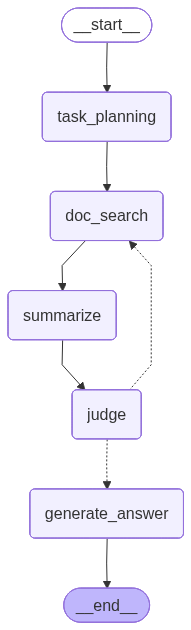

In [ ]:
# LangGraph Workflow グラフの構築と可視化
# Gradio では各ノード関数を直接呼び出すが、グラフ定義は Workflow の構造を示すために保持する。


async def _node_task_planning(state: WorkflowState) -> dict:
    subtasks, _ = await run_task_planning(state["question"], llm.temperature)
    return {"subtasks": subtasks, "search_results": [], "summary": "", "loop_count": 0}


async def _node_doc_search(state: WorkflowState) -> dict:
    results, _ = await run_doc_search(state["subtasks"])
    existing = list(state.get("search_results") or [])
    return {"search_results": existing + results, "subtasks": []}


async def _node_summarize(state: WorkflowState) -> dict:
    summary, _ = await run_summarize(
        state["question"], state["search_results"], llm.temperature
    )
    return {"summary": summary}


async def _node_judge(state: WorkflowState) -> dict:
    loop_count = state.get("loop_count", 0)
    if loop_count >= MAX_LOOP_COUNT:
        return {"subtasks": [], "loop_count": loop_count}
    judgment, _ = await run_judge(state["question"], state["summary"], llm.temperature)
    additional = []
    if not judgment.sufficient and judgment.additional_subtasks:
        additional = [st.model_dump() for st in judgment.additional_subtasks]
    return {"subtasks": additional, "loop_count": loop_count + 1}


def _should_continue(state: WorkflowState) -> str:
    return "doc_search" if state.get("subtasks") else "generate_answer"


async def _node_generate_answer(state: WorkflowState) -> dict:
    # 回答生成には生の検索結果を使用する（情報の正確性を保持）
    results_text = "\n\n".join(state["search_results"])
    response = await llm.ainvoke(
        [
            SystemMessage(content=SYSTEM_PROMPT_GENERATE_ANSWER),
            HumanMessage(
                content=f"質問: {state['question']}\n\n検索結果:\n{results_text}"
            ),
        ]
    )
    return {"answer": response.content or ""}


# グラフ構築
wf = StateGraph(WorkflowState)
wf.add_node("task_planning", _node_task_planning)
wf.add_node("doc_search", _node_doc_search)
wf.add_node("summarize", _node_summarize)
wf.add_node("judge", _node_judge)
wf.add_node("generate_answer", _node_generate_answer)
wf.add_edge(START, "task_planning")
wf.add_edge("task_planning", "doc_search")
wf.add_edge("doc_search", "summarize")
wf.add_edge("summarize", "judge")
wf.add_conditional_edges(
    "judge",
    _should_continue,
    {"doc_search": "doc_search", "generate_answer": "generate_answer"},
)
wf.add_edge("generate_answer", END)
workflow_app = wf.compile()

# グラフの可視化
display(Image(workflow_app.get_graph().draw_mermaid_png()))

**Gradio UI の実装**
- 左カラム: PDF ファイルのドラッグ＆ドロップ入力と、AI の思考過程の表示
- 右カラム: マルチターン対応のチャットインターフェース（会話履歴スクロール可能）
  - システムプロンプト設定（アコーディオン内、デフォルト非表示）
  - Temperature スライダー（0.0〜1.0）で応答の正確さ/創造性を調整
  - 送信 / 生成停止 / 会話クリア ボタンを配置
- PDF をアップロードすると、前処理・チャンク分割・インデックス構築が実行される。
- ユーザの質問ごとに RAG Workflow（タスク分割→検索→判定→回答生成）が実行される。
- 思考過程（タスクの内容、検索の内容、判断結果）はチャットとは別の領域に表示する。
- 最終回答はストリーミングで表示する。
- `gr.State()` でユーザー（ブラウザタブ）ごとにセッション状態を管理する。
- `share=True` で Colab 環境からでもパブリック URL でアクセス可能。

In [ ]:
# Gradio UI: PDF アップロード + RAG Workflow チャット（ストリーミング応答）
import uuid
import gradio as gr  # type: ignore


def on_pdf_upload(filepath: str, state: dict) -> tuple[str, list, dict, str]:
    """PDF アップロード時: 前処理・インデックス構築を行い、ステータスを返す。

    Args:
        filepath: Gradio の File コンポーネントが生成した一時ファイルパス。
        state: セッション状態。

    Returns:
        tuple: (ステータス表示, チャット履歴リセット, 更新state, 思考ログリセット)
    """
    if filepath is None:
        return "PDF ファイルをドラッグ＆ドロップしてください。", [], state, ""

    text = process_and_index_pdf(filepath)

    new_state = state.copy()
    new_state["pdf_text"] = text
    new_state["thread_id"] = str(uuid.uuid4())

    status = f"PDF 読み込み完了: {len(_chunks)} チャンク\n文字数: {len(text)}"
    return (
        status,
        [],
        new_state,
        f"PDF インデックス構築完了（{len(_chunks)} チャンク）\n",
    )


def on_clear_chat(state: dict) -> tuple[list, dict, str]:
    """会話履歴をクリアし、新しいスレッド ID を発行する。"""
    new_state = state.copy()
    new_state["thread_id"] = str(uuid.uuid4())
    return [], new_state, ""


async def respond(
    message: str,
    chat_history: list,
    state: dict,
    system_prompt: str,
    temperature: float,
):
    """ユーザのメッセージに対し RAG Workflow を実行し、ストリーミングで応答する。

    思考過程（タスク分割・検索・要約・判定）をリアルタイム表示し、
    最終回答をトークン単位でストリーミングする。

    Workflow の流れ:
    1. task_planning: サブタスク作成
    2. doc_search: 検索実行
    3. summarize: 検索結果の要約（Judge の入力コンテキスト削減）
    4. judge: 情報の十分性判定（要約を入力とするため高速）
    5. generate_answer: 最終回答のストリーミング生成

    Args:
        message: ユーザが入力したメッセージ。
        chat_history: Gradio Chatbot 形式の会話履歴。
        state: セッション状態。
        system_prompt: LLM に与えるシステムプロンプト。
        temperature: LLM の temperature パラメータ。

    Yields:
        tuple: (入力欄クリア, 会話履歴, state, 思考ログ)
    """
    # PDF 未読み込みチェック
    if not _chunks:
        chat_history = chat_history + [
            {"role": "user", "content": message},
            {
                "role": "assistant",
                "content": "PDF ファイルをアップロードしてください。",
            },
        ]
        yield "", chat_history, state, "⚠️ PDF が未読み込みです。\n"
        return

    # 空入力の防止
    if not message.strip():
        yield "", chat_history, state, ""
        return

    chat_history = chat_history + [
        {"role": "user", "content": message},
        {"role": "assistant", "content": ""},
    ]
    thinking = ""

    # --- Phase 1: タスク分割 ---
    thinking += "📋 タスク分割中...\n"
    yield "", chat_history, state, thinking

    subtasks, log = await run_task_planning(message, temperature)
    thinking += log + "\n"
    yield "", chat_history, state, thinking

    # --- Phase 2: 検索 + 要約 + 判定ループ ---
    search_results: list[str] = []
    loop_count = 0
    current_subtasks = subtasks

    while current_subtasks:
        # 検索
        thinking += "🔍 ドキュメント検索中...\n"
        yield "", chat_history, state, thinking

        new_results, log = await run_doc_search(current_subtasks)
        search_results.extend(new_results)
        thinking += log + "\n"
        yield "", chat_history, state, thinking

        loop_count += 1
        if loop_count > MAX_LOOP_COUNT:
            thinking += "⚠️ ループ上限に到達 → 回答作成へ\n\n"
            yield "", chat_history, state, thinking
            break

        # 要約（検索結果を圧縮して Judge の負荷を軽減）
        thinking += "📝 検索結果を要約中...\n"
        yield "", chat_history, state, thinking

        summary, log = await run_summarize(message, search_results, temperature)
        thinking += log + "\n"
        yield "", chat_history, state, thinking

        # 判定（要約テキストを入力とするため高速）
        thinking += "⚖️ 情報の十分性を判定中...\n"
        yield "", chat_history, state, thinking

        judgment, log = await run_judge(message, summary, temperature)
        thinking += log + "\n"
        yield "", chat_history, state, thinking

        if judgment.sufficient:
            break

        # 不足時: Judge が生成した additional_subtasks を使用
        current_subtasks = [
            st.model_dump() for st in (judgment.additional_subtasks or [])
        ]

    # --- Phase 3: 回答生成（ストリーミング） ---
    thinking += "✏️ 回答を生成中...\n"
    yield "", chat_history, state, thinking

    # 回答生成には生の検索結果を使用する（情報の正確性を保持）
    results_text = "\n\n".join(search_results)

    # システムプロンプト構築
    sys_content = system_prompt + "\n\n" + SYSTEM_PROMPT_GENERATE_ANSWER

    # マルチターン対応: 直近の会話履歴をコンテキストに含める
    # 現在の質問（末尾2件）は除外し、直近4メッセージ（2往復）まで含める
    recent_history = chat_history[:-2][-4:]
    history_lines = []
    for msg in recent_history:
        role = "ユーザ" if msg["role"] == "user" else "AI"
        history_lines.append(f"{role}: {msg['content'][:500]}")

    user_content = ""
    if history_lines:
        user_content += "会話履歴:\n" + "\n".join(history_lines) + "\n\n"
    user_content += f"質問: {message}\n\n検索結果:\n{results_text}"

    llm_instance = _make_llm(temperature)
    bot_reply = ""
    async for chunk in llm_instance.astream(
        [
            SystemMessage(content=sys_content),
            HumanMessage(content=user_content),
        ]
    ):
        if chunk.content:
            bot_reply += chunk.content
            chat_history = chat_history[:-1] + [
                {"role": "assistant", "content": bot_reply}
            ]
            yield "", chat_history, state, thinking

    thinking += "✅ 回答生成完了\n"
    yield "", chat_history, state, thinking


# --- Gradio UI の構築 ---
with gr.Blocks(title="RAG チャットアシスタント") as demo:
    gr.Markdown("### RAG チャットアシスタント（AI Agent Workflow + RAG）")

    session_state = gr.State(
        {
            "pdf_text": "",
            "thread_id": str(uuid.uuid4()),
        }
    )

    with gr.Row():
        # 左カラム: PDF アップロード + 思考過程
        with gr.Column(scale=1):
            pdf_input = gr.File(
                label="PDF ファイルをドラッグ＆ドロップ",
                file_types=[".pdf"],
                type="filepath",
            )
            pdf_status = gr.Textbox(
                label="PDF ステータス",
                lines=2,
                max_lines=2,
                interactive=False,
            )
            thinking_display = gr.Textbox(
                label="AI の思考過程",
                lines=25,
                max_lines=25,
                interactive=False,
            )

        # 右カラム: チャットインターフェース
        with gr.Column(scale=1):
            chatbot = gr.Chatbot(
                label="AI チャット",
                height=400,
            )

            with gr.Accordion("システムプロンプト設定 (任意)", open=False):
                system_prompt_input = gr.Textbox(
                    label="システムプロンプト",
                    value="日本語で回答してください。",
                    lines=2,
                )

            temp_slider = gr.Slider(
                minimum=0.0,
                maximum=1.0,
                value=llm.temperature,
                step=0.1,
                label="Temperature (低いほど正確、高いほど創造的)",
            )

            msg_input = gr.Textbox(
                label="メッセージを入力",
                placeholder="質問を入力してください...",
                lines=2,
            )
            with gr.Row():
                send_btn = gr.Button("送信", variant="primary")
                stop_btn = gr.Button("生成を停止", variant="stop")
                clear_btn = gr.Button("会話をクリア", variant="secondary")

    # --- イベントハンドラの設定 ---

    # PDF アップロード
    pdf_input.change(
        on_pdf_upload,
        inputs=[pdf_input, session_state],
        outputs=[pdf_status, chatbot, session_state, thinking_display],
    )

    # 送信（ストリーミング応答）
    submit_args = dict(
        fn=respond,
        inputs=[
            msg_input,
            chatbot,
            session_state,
            system_prompt_input,
            temp_slider,
        ],
        outputs=[msg_input, chatbot, session_state, thinking_display],
    )
    submit_event_click = send_btn.click(**submit_args)
    submit_event_enter = msg_input.submit(**submit_args)

    # 生成停止ボタン
    stop_btn.click(
        fn=None,
        inputs=None,
        outputs=None,
        cancels=[submit_event_click, submit_event_enter],
    )

    # 会話クリアボタン
    clear_btn.click(
        on_clear_chat,
        inputs=[session_state],
        outputs=[chatbot, session_state, thinking_display],
    )

# Colab 環境では share=True でパブリック URL を生成する
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7c375f68ba15451308.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


テキスト文字数: 79515
チャンク数: 214
ChromaDB: 214 件格納
BM25 インデックス構築完了: 214 件


In [11]:
demo.close()

Closing server running on port: 7860
